In [1]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

2024-10-10 13:29:17.339766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 13:29:17.341633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 13:29:17.351176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 13:29:17.368938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 13:29:17.399843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [3]:
risk = "hi_gauss_blob_risk_fun"

In [4]:
dict = parse_variables('geno_simulation.txt')
G = 100
L = 10
c = 1000
k = 3
M = 20
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, geno = simulate_genos(G, L, c, k, M, HWE)
proto_geno = geno.copy()

In [5]:
humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

In [6]:
true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(geno, humans)
#true_p2s['pop'] = humans['populations']
#true_q2s['pop'] = humans['populations']
#true_twopqs['pop'] = humans['populations']

# Check PCA

In [7]:
scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

In [8]:
PC_geno['populations'] = humans['populations']

In [9]:
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [f"pop {i+1}"]*c
populations = pd.DataFrame(labels_pop, columns=['populations'])

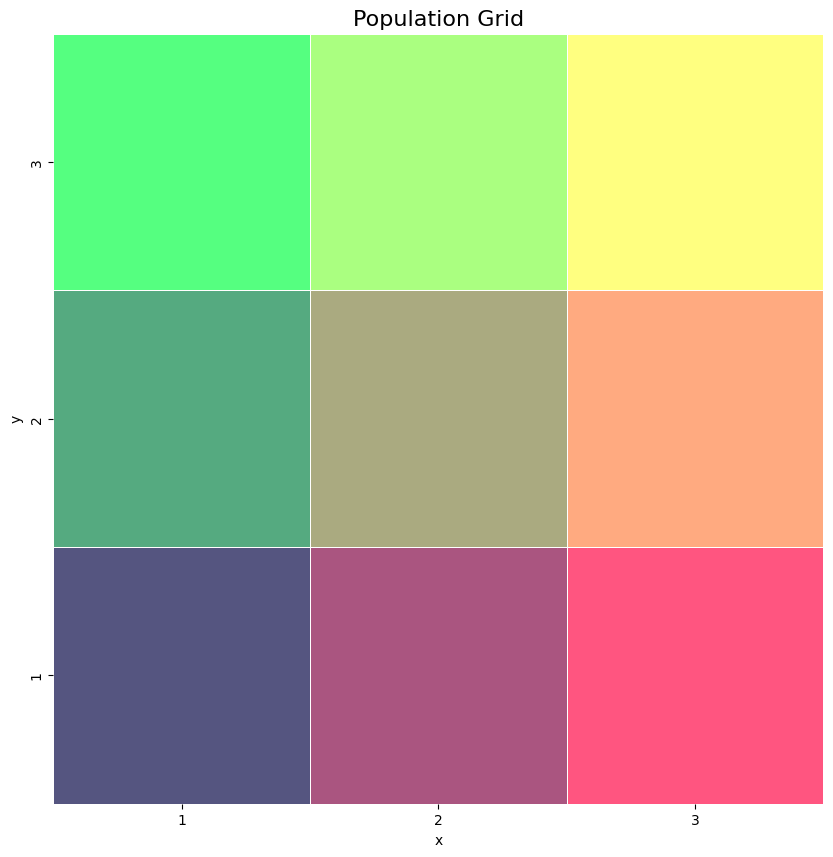

In [10]:
humans
humans['x'] = ((humans['populations'] - 1) % k) + 1
humans['y'] = ((humans['populations'] - 1) // k) + 1
humans['z'] = 0.5
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

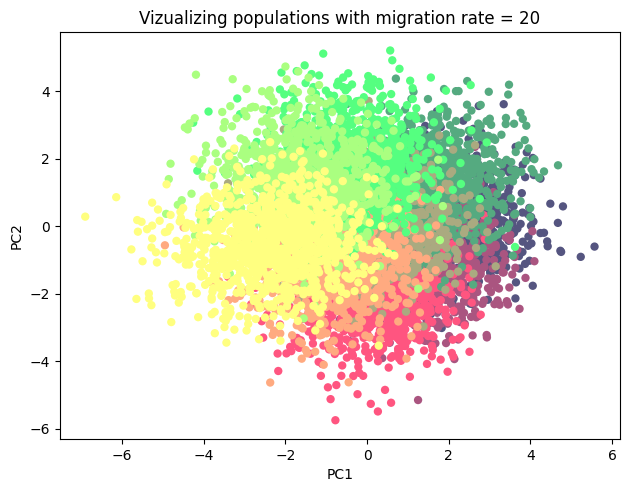

In [11]:
sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

In [12]:
# get correction

In [13]:
maf_dfs = pd.DataFrame(np.where(proto_geno == 1.0, true_p2s, np.where(proto_geno == 0.0, true_twopqs, true_q2s)), columns=proto_geno.columns)

In [14]:
geno = np.where((geno == 0) & (true_q2s == 0.0), -1, geno)
geno = pd.DataFrame(geno, columns=proto_geno.columns)

# Update true_q2s where geno == 0 and true_q2s == 0.0 to take values from true_twopqs
true_q2s = np.where((proto_geno == 0) & (true_q2s == 0.0), true_twopqs, true_q2s)
true_q2s = pd.DataFrame(true_q2s, columns=proto_geno.columns)

geno = np.where((geno == 0) & (true_p2s == 0.0), 1, geno)
geno = pd.DataFrame(geno, columns=proto_geno.columns)

# Update true_q2s where geno == 0 and true_q2s == 0.0 to take values from true_twopqs
true_p2s = np.where((proto_geno == 0) & (true_p2s == 0.0), true_twopqs, true_p2s)
true_p2s = pd.DataFrame(true_p2s, columns=proto_geno.columns)

In [15]:
correction = geno/maf_dfs

In [16]:
# Check if any column contains NaN values
nan_columns = correction.isna().any()

# Check if any column contains inf values (both positive and negative inf)
inf_columns = correction.isin([np.inf, -np.inf]).any()

# Combine NaN and inf column checks into one dataframe for easier viewing
nan_inf_summary = pd.DataFrame({
    'NaN': nan_columns,
    'inf': inf_columns
})

# Show the columns that contain NaN or inf values
nan_inf_summary[nan_inf_summary['NaN'] | nan_inf_summary['inf']]

,NaN,inf
snps,,


In [17]:
# Replace inf values (-inf and inf) with NaN first (to handle both at once)
correction.replace([np.inf, -np.inf], 0, inplace=True)

In [18]:
# calibrating
for col in correction.columns:
    X = correction[[col]]
    y = geno[col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[col]
    correction[col] = correction[col]*beta

In [19]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

In [20]:
risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

<Axes: xlabel='x', ylabel='y'>

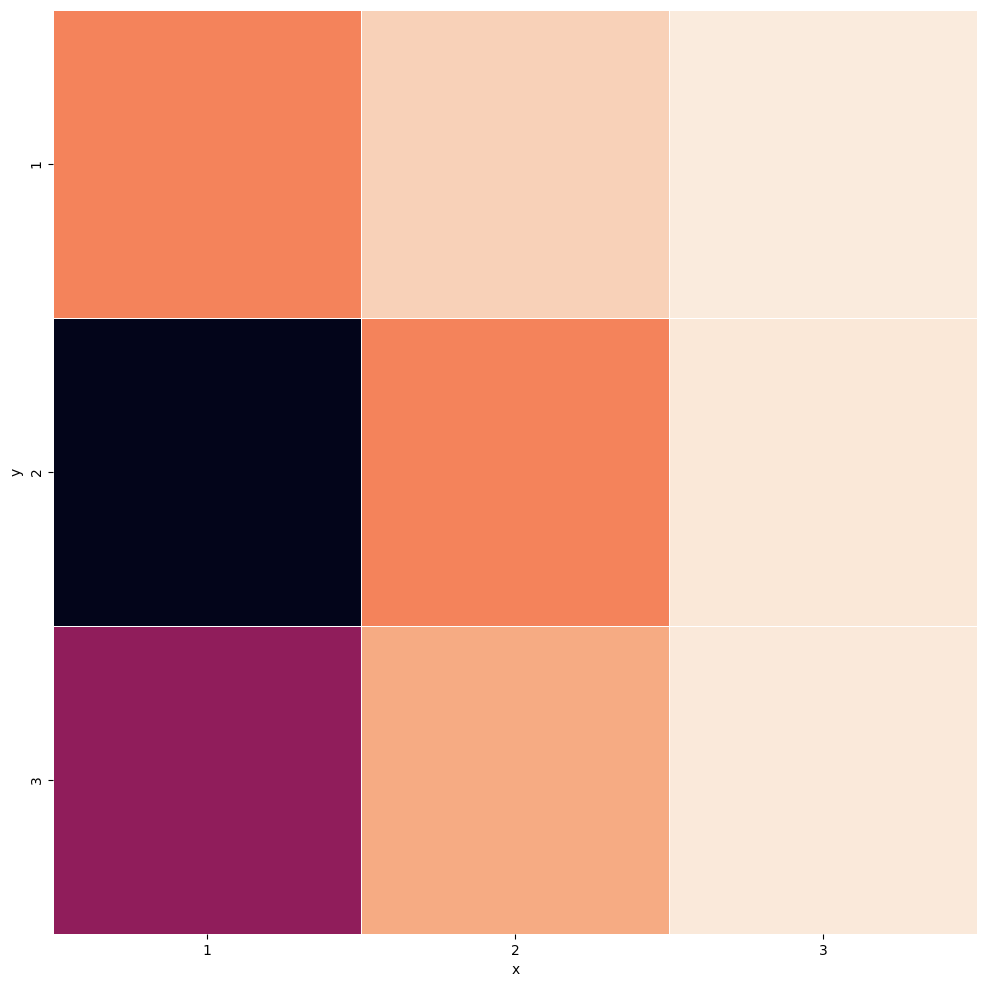

In [21]:
# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [22]:
to_check = list(geno.columns)[0]

In [23]:
humans['snp'] = geno[to_check]
humans['pop'] = PC_geno['populations']
humans['risk'] = humans[name_risk] - humans[name_risk].mean()

In [24]:
humans

,populations,x,y,z,x_temp,y_temp,hi_gauss_blob_risk,snp,pop,risk
0,1,1,1,0.5,0.333333,0.333333,0.471754,-1.0,1,-0.011308
1,1,1,1,0.5,0.333333,0.333333,0.471754,1.0,1,-0.011308
2,1,1,1,0.5,0.333333,0.333333,0.471754,0.0,1,-0.011308
3,1,1,1,0.5,0.333333,0.333333,0.471754,1.0,1,-0.011308
4,1,1,1,0.5,0.333333,0.333333,0.471754,0.0,1,-0.011308
...,...,...,...,...,...,...,...,...,...,...
8995,9,3,3,0.5,1.000000,1.000000,0.013476,1.0,9,-0.469586
8996,9,3,3,0.5,1.000000,1.000000,0.013476,1.0,9,-0.469586
8997,9,3,3,0.5,1.000000,1.000000,0.013476,0.0,9,-0.469586
8998,9,3,3,0.5,1.000000,1.000000,0.013476,0.0,9,-0.469586


In [25]:
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.08176111521495066


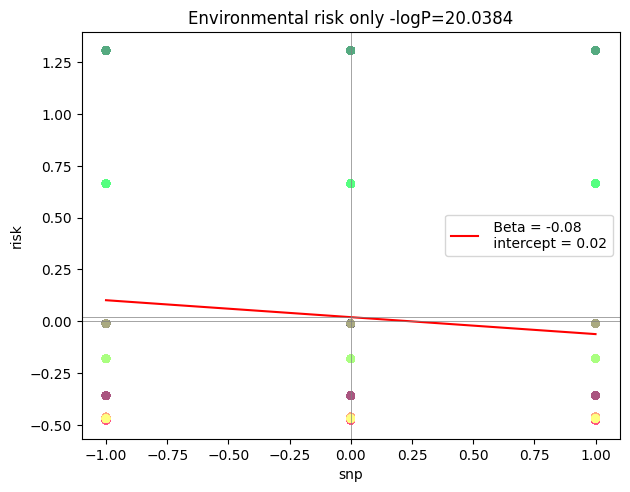

In [26]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [27]:
humans['corr'] = correction[to_check]

In [28]:
X = humans[['corr']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['corr']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['corr']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-1.6132928326584306e-16


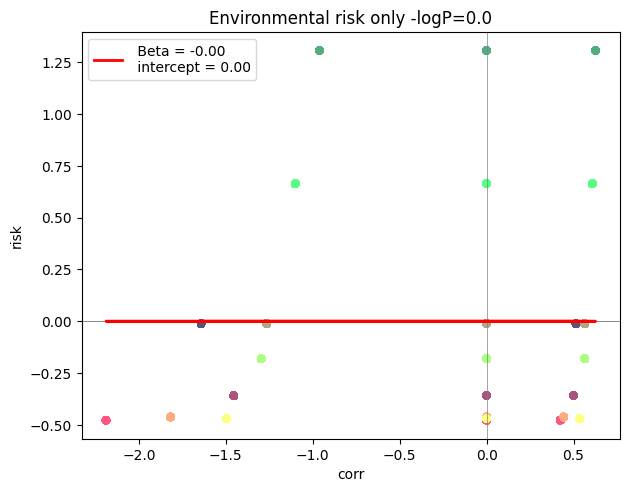

In [29]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='corr', y='risk', data=humans, color=palette, linewidth=0, legend=False)

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['corr'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# Go over all the snps

In [30]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [31]:
mafs = []
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], y)

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])
    mafs.append(float(snp.split('_')[-1]))

In [32]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols
to_compare['mafs'] = mafs
# Remove or cap the 'inf' values and extremely large numbers
to_compare = to_compare.replace([np.inf, -np.inf], np.nan)  # Replace 'inf' with NaN
to_compare['logP_snps'] = np.clip(to_compare['logP_snps'], 0, 200)  # Cap values at 100
to_compare['logP_mafs_ols'] = np.clip(to_compare['logP_mafs_ols'], 0, 200)  # Cap values at 100


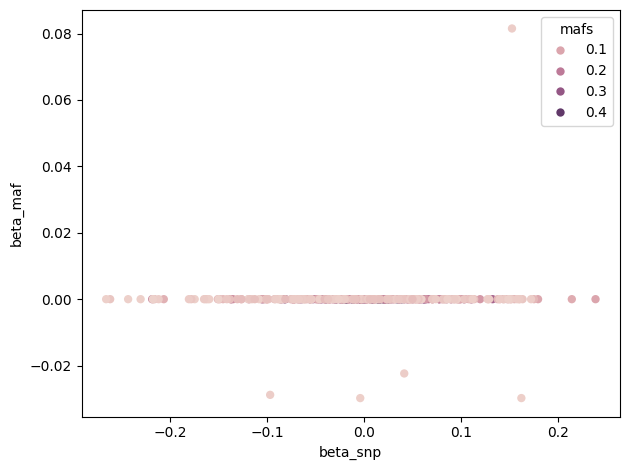

In [33]:
# Plot
sns.scatterplot(x='beta_snp', y='beta_maf', data=to_compare, hue='mafs', linewidth=0)
plt.tight_layout()
plt.title("")
plt.show()
plt.close()

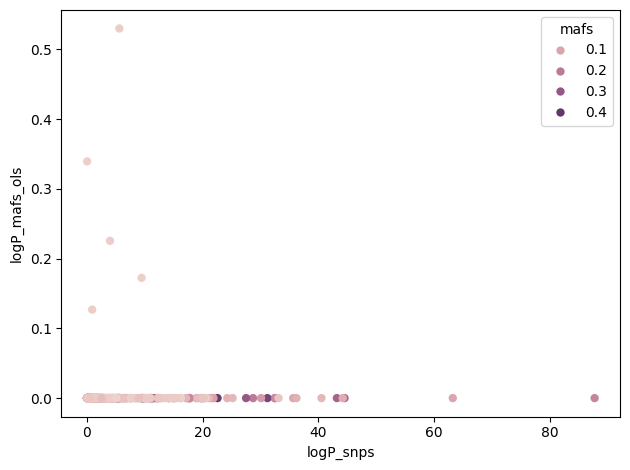

In [34]:
sns.scatterplot(x='logP_snps', y='logP_mafs_ols',data=to_compare, hue= 'mafs',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

In [35]:
y = humans['risk']
betas_snps = []
betas_correction = []
betas_abyss = []

intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_correction = []
logP_abyss = []

In [36]:
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    beta_correction = manhattan_linear(correction[[f"{snp}"]], y)
    beta_abyss = manhattan_linear(geno[[snp]], y, true_p2s[[f"{snp}"]]-true_q2s[[f"{snp}"]])
    
    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_correction.append(beta_correction['coefs'][0])
    logP_correction.append(beta_correction['-logPs'][0])
    
    betas_abyss.append(beta_abyss['coefs'][0])
    logP_abyss.append(beta_abyss['-logPs'][0])
    

In [37]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_correction'] = betas_correction
to_compare['beta_abyss'] = betas_abyss


to_compare['logP_snps'] = logP_snps
to_compare['logP_correction'] = logP_correction
to_compare['logP_abyss'] = logP_abyss
betas_long = to_compare[['beta_snp', 'beta_correction', 'beta_abyss']].melt(var_name='Beta_Type', value_name='Beta_Value')
betas_long['True_Beta'] = 0

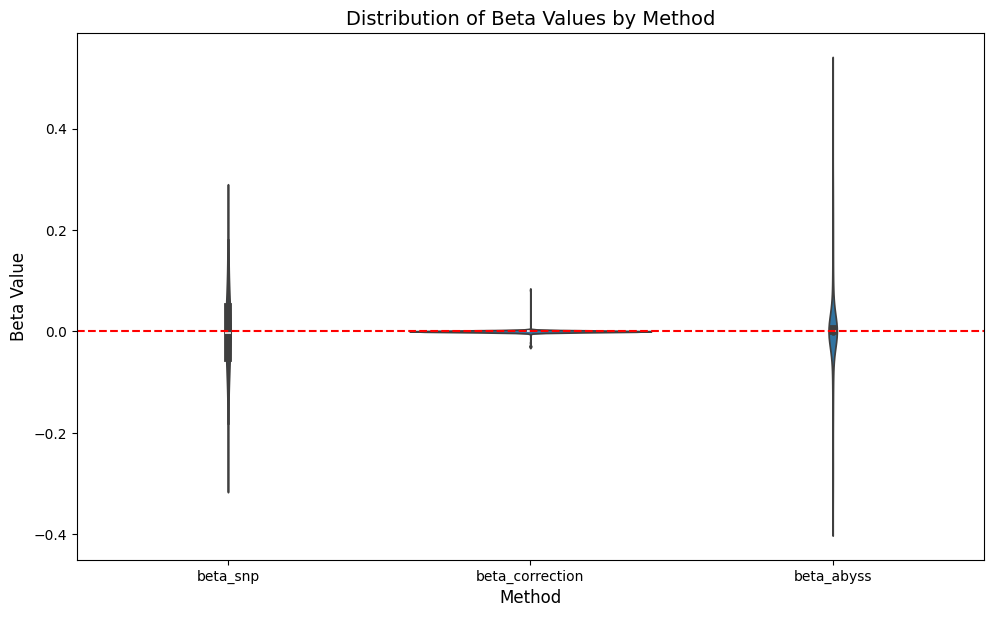

In [38]:
plt.figure(figsize=(10, 6))  # Increase plot size for better readability
sns.violinplot(x='Beta_Type', y='Beta_Value', data=betas_long)
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.title("Distribution of Beta Values by Method", fontsize=14)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Beta Value", fontsize=12)

plt.show()
plt.close()


# Find Ypops with mafs

In [39]:
p_min_q = true_p2s-true_q2s

In [40]:
p_min_q['pop'] = humans['populations']

In [41]:
p_min_q['pheno'] = humans['risk']

In [47]:
y_preds = []
for pop in p_min_q['pop'].unique():
    temp_p_min_q = p_min_q[p_min_q['pop'] == pop]
    snps = [f for f in temp_p_min_q.columns if not f.startswith('p')]
    y_pred = pd.DataFrame()
    for snp in snps:
        beta_snps = manhattan_linear(temp_p_min_q[[snp]], temp_p_min_q['pheno'])
        temp_p_min_q[[snp]]
        y_pred[snp] = temp_p_min_q[snp]*beta_snps.coefs[0]
    y_pred.index = temp_p_min_q.index
    y_preds.append(y_pred)

In [48]:
y_preds = pd.concat(y_preds)

In [56]:
new_y = -y_preds + humans['risk'].values[:, None]
new_y

,CG14_AF_0.37855555555555553,CG18_AF_0.3586666666666667,CG19_AF_0.36183333333333334,CG46_AF_0.4176111111111111,CG61_AF_0.24544444444444444,CG65_AF_0.2021111111111111,CG67_AF_0.25116666666666665,CG69_AF_0.25066666666666665,CG84_AF_0.2238888888888889,CG87_AF_0.4152777777777778,...,VRG463_AF_0.011944444444444445,VRG464_AF_0.007166666666666667,VRG467_AF_0.010722222222222222,VRG481_AF_0.014722222222222222,VRG487_AF_0.0135,VRG492_AF_0.016777777777777777,VRG493_AF_0.0030555555555555557,VRG495_AF_0.02738888888888889,VRG497_AF_0.03666666666666667,VRG499_AF_0.0455
0,-2.255141e-17,1.040834e-17,1.908196e-17,2.081668e-17,2.255141e-17,-1.387779e-17,6.938894e-18,2.255141e-17,1.734723e-18,-1.734723e-17,...,-1.130802e-02,-1.130802e-02,-0.011308,-1.734723e-17,-0.011308,-1.130802e-02,-0.011308,-1.130802e-02,2.428613e-17,-5.204170e-18
1,-2.255141e-17,1.040834e-17,1.908196e-17,2.081668e-17,2.255141e-17,-1.387779e-17,6.938894e-18,2.255141e-17,1.734723e-18,-1.734723e-17,...,-1.130802e-02,-1.130802e-02,-0.011308,-1.734723e-17,-0.011308,-1.130802e-02,-0.011308,-1.130802e-02,2.428613e-17,-5.204170e-18
2,-2.255141e-17,1.040834e-17,1.908196e-17,2.081668e-17,2.255141e-17,-1.387779e-17,6.938894e-18,2.255141e-17,1.734723e-18,-1.734723e-17,...,-1.130802e-02,-1.130802e-02,-0.011308,-1.734723e-17,-0.011308,-1.130802e-02,-0.011308,-1.130802e-02,2.428613e-17,-5.204170e-18
3,-2.255141e-17,1.040834e-17,1.908196e-17,2.081668e-17,2.255141e-17,-1.387779e-17,6.938894e-18,2.255141e-17,1.734723e-18,-1.734723e-17,...,-1.130802e-02,-1.130802e-02,-0.011308,-1.734723e-17,-0.011308,-1.130802e-02,-0.011308,-1.130802e-02,2.428613e-17,-5.204170e-18
4,-2.255141e-17,1.040834e-17,1.908196e-17,2.081668e-17,2.255141e-17,-1.387779e-17,6.938894e-18,2.255141e-17,1.734723e-18,-1.734723e-17,...,-1.130802e-02,-1.130802e-02,-0.011308,-1.734723e-17,-0.011308,-1.130802e-02,-0.011308,-1.130802e-02,2.428613e-17,-5.204170e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1.110223e-15,4.996004e-16,9.436896e-16,-3.330669e-16,1.054712e-15,-3.330669e-16,-6.661338e-16,5.551115e-16,1.110223e-15,-5.551115e-17,...,6.106227e-16,4.440892e-16,-0.469586,5.551115e-16,-0.469586,7.771561e-16,-0.469586,-4.996004e-16,-6.661338e-16,4.996004e-16
8996,1.110223e-15,4.996004e-16,9.436896e-16,-3.330669e-16,1.054712e-15,-3.330669e-16,-6.661338e-16,5.551115e-16,1.110223e-15,-5.551115e-17,...,6.106227e-16,4.440892e-16,-0.469586,5.551115e-16,-0.469586,7.771561e-16,-0.469586,-4.996004e-16,-6.661338e-16,4.996004e-16
8997,1.110223e-15,4.996004e-16,9.436896e-16,-3.330669e-16,1.054712e-15,-3.330669e-16,-6.661338e-16,5.551115e-16,1.110223e-15,-5.551115e-17,...,6.106227e-16,4.440892e-16,-0.469586,5.551115e-16,-0.469586,7.771561e-16,-0.469586,-4.996004e-16,-6.661338e-16,4.996004e-16
8998,1.110223e-15,4.996004e-16,9.436896e-16,-3.330669e-16,1.054712e-15,-3.330669e-16,-6.661338e-16,5.551115e-16,1.110223e-15,-5.551115e-17,...,6.106227e-16,4.440892e-16,-0.469586,5.551115e-16,-0.469586,7.771561e-16,-0.469586,-4.996004e-16,-6.661338e-16,4.996004e-16


In [50]:
correction

snps,CG14_AF_0.37855555555555553,CG18_AF_0.3586666666666667,CG19_AF_0.36183333333333334,CG46_AF_0.4176111111111111,CG61_AF_0.24544444444444444,CG65_AF_0.2021111111111111,CG67_AF_0.25116666666666665,CG69_AF_0.25066666666666665,CG84_AF_0.2238888888888889,CG87_AF_0.4152777777777778,...,VRG463_AF_0.011944444444444445,VRG464_AF_0.007166666666666667,VRG467_AF_0.010722222222222222,VRG481_AF_0.014722222222222222,VRG487_AF_0.0135,VRG492_AF_0.016777777777777777,VRG493_AF_0.0030555555555555557,VRG495_AF_0.02738888888888889,VRG497_AF_0.03666666666666667,VRG499_AF_0.0455
0,-1.641877,0.000000,0.000000,0.000000,0.206967,0.000000,0.205654,0.000000,0.000000,0.000000,...,-0.273348,0.004622,0.009608,0.004849,0.004858,0.005620,0.004750,0.004834,0.005228,0.005229
1,0.514123,-1.641533,0.462009,0.000000,0.206967,-2.102033,0.000000,0.186482,0.133021,0.000000,...,0.008745,0.004622,0.009608,0.004849,0.004858,0.005620,0.004750,0.004834,0.005228,0.005229
2,0.000000,-1.641533,0.000000,0.552618,0.000000,0.000000,0.000000,0.000000,0.000000,0.658078,...,0.008745,0.004622,0.009608,0.004849,0.004858,0.005620,0.004750,0.004834,0.005228,0.005229
3,0.514123,0.000000,0.000000,0.000000,0.000000,0.106471,0.205654,0.000000,0.133021,0.000000,...,0.008745,0.004622,0.009608,0.004849,0.004858,0.005620,0.004750,0.004834,0.005228,0.005229
4,0.000000,0.000000,0.462009,0.552618,0.000000,0.106471,0.205654,-1.190617,0.133021,0.000000,...,0.008745,0.004622,0.009608,0.004849,0.004858,0.005620,0.004750,0.004834,0.005228,0.005229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.535770,0.462897,0.508559,0.000000,0.174962,0.000000,0.149734,0.137582,0.000000,0.702352,...,0.008827,0.004830,0.009657,0.000000,0.004960,0.005574,0.004741,0.005161,0.005245,0.005217
8996,0.535770,-1.575343,0.508559,-1.113651,0.174962,0.000000,0.149734,0.000000,0.157499,-1.131375,...,0.008827,0.004830,0.009657,0.004849,0.004960,0.005574,0.004741,0.005161,0.005245,0.005217
8997,0.000000,0.000000,0.000000,0.000000,0.174962,0.122619,0.149734,0.000000,0.000000,0.702352,...,0.008827,0.004830,0.009657,0.000000,0.004960,0.005574,0.004741,0.005161,0.005245,0.005217
8998,0.000000,0.000000,0.000000,0.000000,0.174962,0.122619,0.149734,0.137582,0.157499,-1.131375,...,0.008827,0.004830,0.009657,0.004849,0.004960,0.005574,0.004741,0.005161,0.005245,0.005217


In [61]:
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []
mafs = []
for snp in correction.columns:
    beta_snps = manhattan_linear(proto_geno[[snp]], y)
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], new_y[f"{snp}"])

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])

    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])
    mafs.append(float(snp.split('_')[-1]))

In [62]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols
to_compare['mafs'] = mafs
# Remove or cap the 'inf' values and extremely large numbers
to_compare = to_compare.replace([np.inf, -np.inf], np.nan)  # Replace 'inf' with NaN
to_compare['logP_snps'] = np.clip(to_compare['logP_snps'], 0, 200)  # Cap values at 100
to_compare['logP_mafs_ols'] = np.clip(to_compare['logP_mafs_ols'], 0, 200)  # Cap values at 100


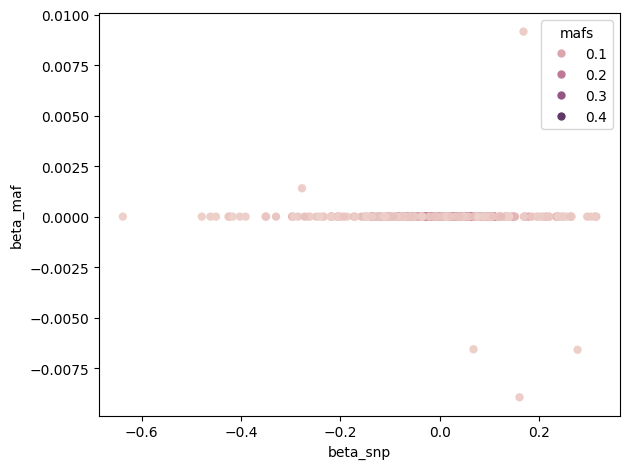

In [63]:
# Plot
sns.scatterplot(x='beta_snp', y='beta_maf', data=to_compare, hue='mafs', linewidth=0)
plt.tight_layout()
plt.title("")
plt.show()
plt.close()

# Causality of SNPs

In [64]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

def multi(arr, effectsize):
    return [num * effectsize for num in arr]

In [65]:
effectsize = 20
noise = 0.999
noise = 1-noise
numbers_af = [float(col.split('_AF_')[1]) for col in geno.columns if '_AF_' in col]
snp_names = [col.split('_AF_')[0] for col in geno.columns if '_AF_' in col]

beta_values = divi(numbers_af, effectsize)
data = {'snp': snp_names, 'Beta': beta_values}
betas = pd.DataFrame(data)


In [67]:
all_snps = list(geno.columns)
phenos_mono = []
for snp in all_snps:
    index_snp = snp.split('_')[0]
    beta_value = betas.loc[betas['snp'] == index_snp, 'Beta'].values[0]
    phenos_mono.append(proto_geno[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = geno.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / noise
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)
    std_dev = np.std(phenos_mono[snp])
    mean = np.mean(phenos_mono[snp])
    phenos_mono[snp] = (phenos_mono[snp] - mean) / std_dev

In [ ]:
y_preds = []
for pop in p_min_q['pop'].unique():
    temp_p_min_q = p_min_q[p_min_q['pop'] == pop]
    snps = [f for f in temp_p_min_q.columns if not f.startswith('p')]
    y_pred = pd.DataFrame()
    for snp in snps:
        beta_snps = manhattan_linear(temp_p_min_q[[snp]], temp_p_min_q['pheno'])
        temp_p_min_q[[snp]]
        y_pred[snp] = temp_p_min_q[snp]*beta_snps.coefs[0]
    y_pred.index = temp_p_min_q.index
    y_preds.append(y_pred)

In [68]:
phenos_mono

snps,CG14_AF_0.37855555555555553,CG18_AF_0.3586666666666667,CG19_AF_0.36183333333333334,CG46_AF_0.4176111111111111,CG61_AF_0.24544444444444444,CG65_AF_0.2021111111111111,CG67_AF_0.25116666666666665,CG69_AF_0.25066666666666665,CG84_AF_0.2238888888888889,CG87_AF_0.4152777777777778,...,VRG463_AF_0.011944444444444445,VRG464_AF_0.007166666666666667,VRG467_AF_0.010722222222222222,VRG481_AF_0.014722222222222222,VRG487_AF_0.0135,VRG492_AF_0.016777777777777777,VRG493_AF_0.0030555555555555557,VRG495_AF_0.02738888888888889,VRG497_AF_0.03666666666666667,VRG499_AF_0.0455
0,1.426436,-0.408668,0.287634,-0.602777,-1.268372,1.488453,-0.199179,1.109069,0.667089,-1.838457,...,-0.564141,-0.214389,-0.963539,0.449699,-0.134802,-0.526841,-0.864640,0.605775,0.031775,-0.646390
1,1.351102,0.845551,-0.403737,-2.608971,2.094526,-1.773314,-1.128818,0.691765,1.865744,0.091522,...,2.234799,-2.094908,-0.467527,-0.687760,-0.419634,-0.832316,-0.795998,0.656064,-0.463610,-0.432467
2,-1.249088,2.567380,1.804370,-1.289581,-0.188214,0.063530,-1.606598,1.141139,1.152140,-1.208338,...,-0.317382,-0.279921,-0.491421,-0.793712,0.794039,0.939435,-0.046709,-0.629698,-0.830370,0.258148
3,-2.784685,1.149808,-0.831305,1.588944,-0.880800,0.193503,-1.436946,-1.011029,-0.479867,0.138985,...,-0.086222,0.685338,-1.007110,1.461498,-0.844800,0.652004,-1.485262,1.596773,0.740687,1.441973
4,0.620526,1.150938,1.354657,0.003425,0.376461,-0.694423,1.579842,-0.325616,-0.653909,0.081489,...,0.266721,-0.039896,1.212622,-0.788634,0.149611,1.456843,-0.530897,1.611390,0.724343,1.950191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.967110,0.400215,1.847589,-1.615186,-1.152894,0.486118,-1.560163,-1.921917,1.105908,0.029288,...,0.992265,1.661619,0.074878,0.422680,-1.259459,-1.035090,0.032943,-1.508782,-1.828757,0.104379
8996,-1.238756,0.825869,-0.095185,-1.541989,-0.870021,-0.622870,-0.314972,-0.172799,-0.253924,-1.450172,...,0.801580,-0.130859,1.202805,-0.974097,0.724781,-0.114268,-0.872266,-1.833035,1.859930,0.617799
8997,-2.266453,-0.312903,-0.017791,0.409933,1.778265,1.725373,-0.409914,-0.274942,0.057150,0.231918,...,0.639388,0.506718,1.311245,1.268694,-1.053916,1.710574,-1.479243,-0.326974,-0.751418,-0.217852
8998,-1.882655,0.940077,0.116347,-0.483594,1.124201,0.355786,0.152175,-0.344150,1.534046,-1.191799,...,2.341259,-0.635426,0.500968,-1.057366,1.232090,-1.087096,1.516127,-0.784602,-0.506652,0.028490


In [74]:
y = humans['risk']
betas_snps = []
betas_mafs_ols = []
intercept_snps = []
intercept_mafs = []

logP_snps = []
logP_mafs_ols = []

In [75]:
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], phenos_mono[snp])
    beta_mafs_ols = manhattan_linear(correction[[f"{snp}"]], phenos_mono[snp])

    betas_snps.append(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])
 
    betas_mafs_ols.append(beta_mafs_ols['coefs'][0])
    logP_mafs_ols.append(beta_mafs_ols['-logPs'][0])

In [411]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['beta_maf'] = betas_mafs_ols

to_compare['logP_snps'] = logP_snps
to_compare['logP_mafs_ols'] = logP_mafs_ols
to_compare['mafs'] = geno.columns

to_compare['mafs'] = to_compare['mafs'].apply(lambda x: float(x.split('_')[-1]))

In [412]:
to_compare

,beta_snp,beta_maf,logP_snps,logP_mafs_ols,mafs
0,0.051444,0.050781,3.222017,3.137098,0.488500
1,0.051625,0.069080,3.061826,4.237288,0.348000
2,0.048547,0.050839,2.854632,2.817154,0.392556
3,0.041717,0.006937,1.747388,0.108239,0.233111
4,0.057371,0.057640,3.204559,2.199267,0.266722
...,...,...,...,...,...
373,0.102750,0.148913,2.148683,1.529991,0.010833
374,0.117430,0.013319,2.718764,0.047996,0.015222
375,0.195912,0.272982,1.805502,1.524627,0.002889
376,0.136379,0.250727,3.432470,1.776429,0.018167


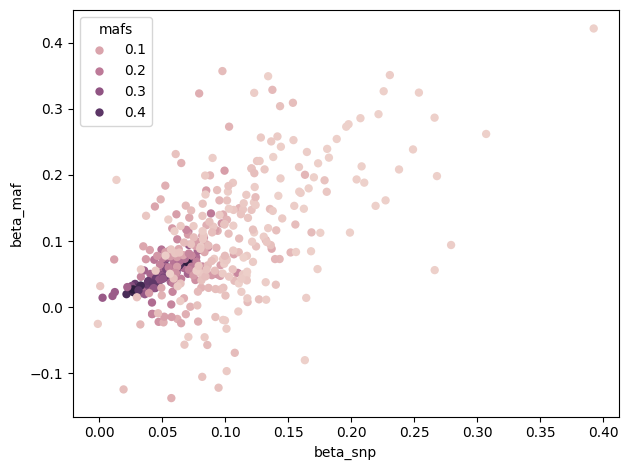

In [413]:
sns.scatterplot(x='beta_snp', y='beta_maf',data=to_compare, hue= 'mafs',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()

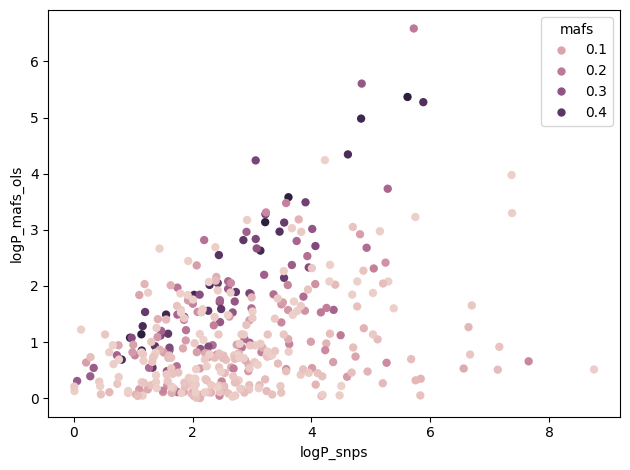

In [414]:
sns.scatterplot(x='logP_snps', y='logP_mafs_ols',data=to_compare, hue= 'mafs',linewidth=0)
# Adjust layout
plt.tight_layout()
plt.title(f"")
plt.show()
plt.close()